#  REGRESSION LOGISTIQUE

# Introduction

Dans cet exercice guidé nous allons pratiquer la régression logistique sous Python via les packages « statsmodels » et « scikit-learn ».

Nous tâcherons de décrire les différentes étapes de la construction du modèle à son évaluation et la mesure de ses performances prédictives.

# A. Utilisation du package scikit-learn

## 1. Import des librairies


Pour commencer nous allons utiliser uniquement le packages scikit-learn
hormis les librairies classiques importez celle utilisée pour la regression logistique et celles pour les métriques necessaires (matrice de confusion, rapport des métriques)



In [109]:
# librairies classiques
import pandas as pd
import numpy as np

# packages scikit-learn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
print(sklearn.__version__)

# packages visualisation
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

1.0.1


## 2. Import du dataset


Nous analysons dans cet exercice les facteurs de risque d'infidélité dans les ménages. 

Nous verrons que le facteur temps est bien évidemment un paramètre qui joue en faveur de l'infidélité. 

Mais pas seulement, d'autres variables également.

In [88]:
# importation du dataset
dataset = pd.read_excel('./data/dataset_infidelites.xlsx')

# visualisation du jeu de données
dataset.head()

,Sex,Age,YearsMarried,Children,Religious,Education,Occupation,RatingMarriage,Infidelite
0,0,22.0,0.75,0,2,18,6,5,0
1,0,32.0,15.00,1,3,14,1,2,1
2,1,27.0,4.00,1,4,20,5,5,0
3,0,22.0,1.50,0,2,16,4,5,0
4,0,27.0,7.00,1,3,14,1,4,0


## 3. Description et visualisation du dataset

### 3.1 Description rapide du dataset

In [89]:
# description rapide du jeu de données
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             601 non-null    int64  
 1   Age             601 non-null    float64
 2   YearsMarried    601 non-null    float64
 3   Children        601 non-null    int64  
 4   Religious       601 non-null    int64  
 5   Education       601 non-null    int64  
 6   Occupation      601 non-null    int64  
 7   RatingMarriage  601 non-null    int64  
 8   Infidelite      601 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 42.4 KB


**Ce que je constate :**

- Dataset de 601 entrées et 9 colonnes dont index.

- Données de type numerique : float et integer.

- Aucune données manquantes ou nulles.

In [90]:
for column in dataset.columns:
    print(column, dataset[column].nunique())

Sex 2
Age 9
YearsMarried 8
Children 2
Religious 5
Education 7
Occupation 7
RatingMarriage 5
Infidelite 2


**Ce que je constate :**

Les données du dataset concernent des individus mariés en donnant des indications sur :

- leur genre (0/1), 
- leur age, 
- le nombre d'années de mariage, 
- si ils ont des enfants (0/1), 
- leur appartenance religieuse, 
- leur nombre d'années d'éducation, 
- leur catégorie d'emploi, 
- le niveau d'évaluation de leur mariage,
- si ils ont été infidèles (0/1).

### 3.2 Brève analyse exploratoire

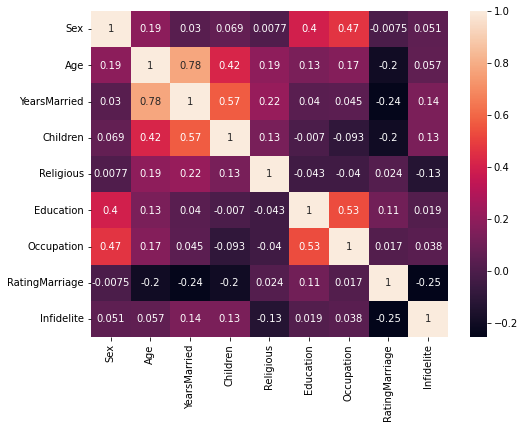

In [91]:
# Affichage de la matrice de correlation
mat_corr = dataset.corr()

# en utilisant matplotlib
#plt.matshow(mat_corr)

# en utilisant seaborn
plt.figure(figsize=(8,6))
sns.heatmap(mat_corr, annot=True) # avec seaborn
plt.show()

#print(mat_corr)

In [92]:
# en visualisant les variables les plus pertinentes
# A premières vues, qu'en déduisez vous ? 

**Ce que je peux déduire :**

La matrice de corrélation permet d'évaluer l'importance et la direction de la relation entre deux variables. Une valeur de corrélation positive élevée indique que les variables mesurent la même caractéristique. Si les items ne sont pas fortement corrélés, ils peuvent mesurer des caractéristiques différentes ou ne pas être clairement définis.

- Certaines paires de variables telles que "Age/YearsMarried", "Children/YearsMarried", "Occupation/Education" indiquent une relation positive. On pourrait dire que plus le nombre d'années de mariage est élevé, plus les valeurs des observations Age et Children sont importantes.

- D'autres posent question, "Infidelite/RatingMarriage", "YearsMarried/RatingMarriage", "Age/RatingMarriage" ou encore "Children/RatingMarriage" en indiquant une relation négative. On pourrait dire que plus la valeur d'évaluation du marriage est basse, plus les valeurs des observations Age, Children, YearsMarried et Infidelité sont importantes.

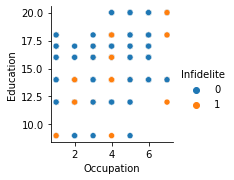

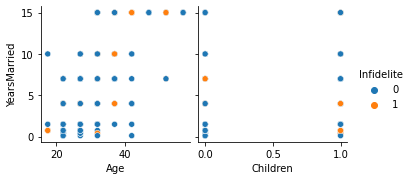

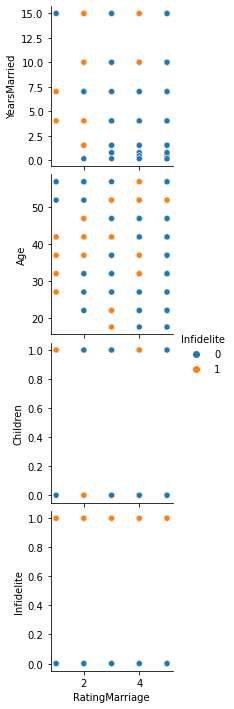

In [93]:
# visualisation plus précise des variables qui semble le plus pertinentes
sns.pairplot(dataset, x_vars=['Occupation'], y_vars=['Education'], hue='Infidelite')
sns.pairplot(dataset, x_vars=['Age', 'Children'], y_vars=['YearsMarried'], hue='Infidelite')
sns.pairplot(dataset, x_vars=['RatingMarriage'], y_vars=['YearsMarried','Age','Children','Infidelite'], hue='Infidelite')

**Ce que je peux déduire :**

- Le nombre d'années d'education a une relation avec l'occupation, plus le nombre d'années est important plus la valeur de la variable Occupation est importante. Mais pas de relation pertinente avec l'infidélité.

- Bien que le nombre d'années de mariage et l'age soit des variables positivement correlées, plus on est agé plus le nombre d'années de mariage est élevé, ces deux variables ne suffisent pas pour établir une relation pertinente avec l'infidélité. On constate cependant qu'entre 5 et 10 années de mariage, l'infidélité est peu ou pas représentée, sauf si il n'y a pas d'enfant. La présence d'enfant dans un ménage de moins de 5 ans semble aussi avoir une importance dans l'infidélité.

- Il n'y a, à priori, pas de relation entre la note d'évaluation du mariage et l'infidélité. Cependant des variables telles que le nombre d'années de mariage et l'age semble contrebalancer cette relation. Les individus satisfaits de leur mariage semblent moins infidèles si ils sont mariés entre 3 et 10 ans ou si ils ont entre 30 et 50 ans.

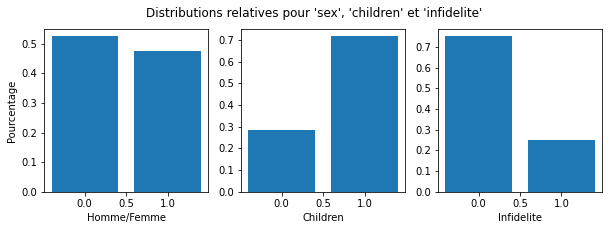

In [94]:
# Distribution relative des catégories 'Sex' et 'Infidelite'
sex = dataset.Sex.value_counts(normalize=True)
indidelite = dataset.Infidelite.value_counts(normalize=True)
children = dataset.Children.value_counts(normalize=True)
religious = dataset.Religious.value_counts(normalize=True)
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.xlabel('Homme/Femme')
plt.ylabel('Pourcentage')
plt.bar(sex.index, sex.values)
plt.subplot(132)
plt.xlabel('Children')
plt.bar(children.index, children.values)
plt.subplot(133)
plt.xlabel('Infidelite')
plt.bar(indidelite.index, indidelite.values)
plt.suptitle("Distributions relatives pour 'sex', 'children' et 'infidelite'")
plt.show()

**Ce que je peux déduire :**

Distribution relative du dataset :

- La répartition homme/femme est quasiment équilibrée.

- La majorité des individus ont des enfants.

- L'infidelité concerne près de 25% des individus.

<AxesSubplot:title={'center':'Relation Religious et Infidelite'}, xlabel='Religious'>

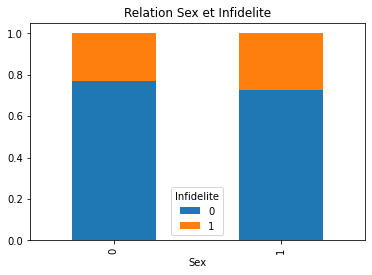

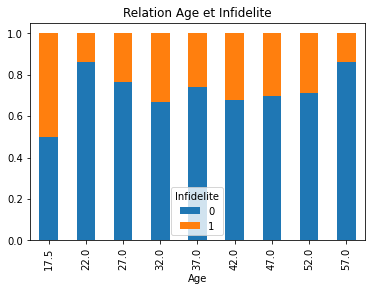

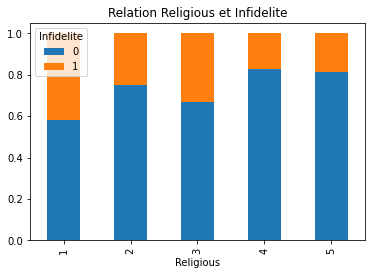

In [95]:
table_sex_infidelite = pd.crosstab(dataset.Sex, dataset.Infidelite)
table_sex_infidelite.div(table_sex_infidelite.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, title="Relation Sex et Infidelite")

table_age_infidelite = pd.crosstab(dataset.Age, dataset.Infidelite)
table_age_infidelite.div(table_age_infidelite.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, title="Relation Age et Infidelite")

table_religon_infidelite = pd.crosstab(dataset.Religious, dataset.Infidelite)
table_religon_infidelite.div(table_religon_infidelite.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, title="Relation Religious et Infidelite")

**Ce que je peux déduire :**

- pas plus d'infidélité chez les hommes que chez les femmes;

- plus d'infidelité chez les moins de 20 ans que chez les plus de 50;

- plus d'infidélité pour chez les individus de catégorie 1 pour la variable Religious;

## 4. Séparation du dataset en Train set et Test set

 Les variables indépendantes sont celles qui sont manipulées (data), tandis que les variables dépendantes sont seulement mesurées ou enregistrées (target). 

In [96]:
# définissez tout d'abord vos variables : indépendantes/ dependante
X = dataset.drop('Infidelite', axis=1)
y = dataset['Infidelite']

In [97]:
# splittez votre dataset de sorte à avoir 1/3 des données dans le test set
test_size = 1/3
X_tn, X_tt, y_tn, y_tt = train_test_split(X, y, test_size=test_size, random_state=0, stratify=y)

In [107]:
# vérifiez le nombre de données y dans chaque jeu (train et test)
print('Nombre de données y : Train :',y_tn.shape,'; Test :', y_tt.shape)
print('Stratification par y : Train :', y_tn.mean(), '; Test :', y_tt.mean())

Nombre de données y : Train : (400,) ; Test : (201,)
Stratification par y : Train : 0.25 ; Test : 0.24875621890547264


**train_test_split() parameters :**

- random_state (int, RandomState instance or None), default=None : Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls. See Glossary.

- shuffle (bool), default=True : Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

- stratify (array-like), default=None : If not None, data is split in a stratified fashion, using this as the class labels

## .5. Entrainement de la regression logistique sur le Train set

In [110]:
# Nous instancions une régression logistique sans pénalité c.-à-d. sans réaliser de régularisation pour l'instant
lr = LogisticRegression(penalty='none')
# lancement de l’estimation des données de training
lr.fit(X_tn, y_tn)

C:\Users\odazo\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty='none')

**Que se passe t - il ?**

Le processus n’a pas convergé alors que le nombre maximal d’itération par défaut est (max_iter = 100).(voir doc)

« Scikit-learn » nous propose alors de :

- soit augmenter le nombre d’itérations (mais trop de puissance de calcul pour un résultat incertain),

- soit de standardiser les données avant de lancer l’algorithme.

La documentation de la régression logistique sous « scikit-learn » nous indique les différents algorithmes d’optimisation qu’il est susceptible d’utiliser (option « solver »).

Ces approches sont sensibles aux différences d’échelles entre les variables, d’où l’indication « scale the data » dans le
« warning » envoyé par la méthode fit()

In [112]:
print(pd.DataFrame({"Variable": X_tn.columns, "Coeff.": lr.coef_[0]}))

         Variable    Coeff.
0             Sex  0.322867
1             Age -0.037457
2    YearsMarried  0.067207
3        Children  0.479657
4       Religious -0.242763
5       Education  0.042252
6      Occupation -0.034653
7  RatingMarriage -0.600989


### Standardisation des données

La doc de la régression logistique sous « scikit-learn » nous indique les différents algorithmes d’optimisation qu’il est susceptible d’utiliser (option « solver »).

Ces approches sont sensibles aux différences d’échelles entre les variables, d’où l’indication « scale the data » dans le « warning » envoyé par la méthode fit().

Nous allons donc centrer et réduire nos données avant de relancer le modèle

In [100]:
#importation de la bibliothèque necessaire à la standardisation
from sklearn import preprocessing
import scipy as sci
#instanciation
scaler = preprocessing.StandardScaler()
scaler.fit(X_tn)
#transformation
X_tn_scaled = scaler.transform(X_tn)
X_tn_scaled = pd.DataFrame(X_tn_scaled, index=X_tn.index, columns=X_tn.columns)
X_tt_scaled = scaler.transform(X_tt)
X_tt_scaled = pd.DataFrame(X_tt_scaled, index=X_tt.index, columns=X_tt.columns)


In [101]:
# imprimer les statistiques de descriptions
X_tn_scaled.mean()
# remarquez que les variables sont bien de moyenne nulle et d’écart-type unitaire.

Sex              -3.885781e-17
Age               1.820766e-16
YearsMarried      8.659740e-17
Children          1.354472e-16
Religious        -1.398881e-16
Education        -5.018208e-16
Occupation       -2.087219e-16
RatingMarriage    4.440892e-17
dtype: float64

In [102]:
X_tn_scaled.std()

Sex               1.001252
Age               1.001252
YearsMarried      1.001252
Children          1.001252
Religious         1.001252
Education         1.001252
Occupation        1.001252
RatingMarriage    1.001252
dtype: float64

In [103]:
#quelles sont les valeurs que peuvent prendre y ? essayer avec attribute_classes


### relancez votre modèle

In [104]:
# relancez le modèle avec les nouvelles valeurs standardisées

#affichez les coefficients

### Dé-standardisation des coefficients

ATTENTION ! nous travaillons sur des données transformées. Nous devons les « dé-standardiser » en les divisant par les écarts-type des variables.


In [105]:
#correction des coefficients -
#  dé-standardisationpar les écarts-type utilisés lors de la standardisation des variables
coefUnstd = classifier_std.coef_[0] / stds.scale_

#affichage des coefficients corrigés


NameError: name 'classifier_std' is not defined

In [ ]:
# on fait de même pour la constante (l'ordonnée à l'origine)
interceptUnStd =classifier_std.intercept_ + np.sum(classifier_std.coef_[0]*(-stds.mean_/stds.scale_))
print(interceptUnStd)


[0.81174835]


## 6. Réaliser des prédictions sur les résultats du Train set

In [ ]:
# calcul des probabilités d'affectation

# on affiche les 5 premières valeurs prédites


array([[0.83464078, 0.16535922],
       [0.85621929, 0.14378071],
       [0.9265064 , 0.0734936 ],
       [0.70229399, 0.29770601],
       [0.48264007, 0.51735993]])

On observe 2 colonnes : la première correspond au proba d'appartenir à Y=0 et la seconde à Y=1

In [ ]:
#et on les compare aux valeurs attendues


          Y=0       Y=1  valeur attendue
569  0.834641  0.165359                0
167  0.856219  0.143781                0
435  0.926506  0.073494                0
413  0.702294  0.297706                0
344  0.482640  0.517360                1
..        ...       ...              ...
335  0.892892  0.107108                0
305  0.733390  0.266610                1
158  0.863535  0.136465                0
401  0.923431  0.076569                0
583  0.869559  0.130441                1

[401 rows x 3 columns]


## 7. Faites des prédictions des résultats du test set

In [ ]:
# nous devons appliquer la même standardisation sur les valeurs du test set ! 

#transformation de l'échantillon test


#stat. descriptives
#print(sci.stats.describe(X1_test,axis=0,ddof=0))

# on applique le modèle à l'échantillon




## 8. Evaluation des performances du modèle à l'aide de la matrice de confusion 

In [ ]:
# affichez la matrice de confusion
cm = 
print(cm)

[[144   6]
 [ 41   9]]


- Combien y a t-il de faux positifs ? combien de faux négatifs ?
- Combien d'éléments sont bien classés? 
- représentez la matrice de confusion sous la forme d'une heatmap

In [ ]:
#affichez le taux d'erreur


0.765


In [ ]:
#affichez le rapport de classification



              precision    recall  f1-score   support

           0       0.78      0.96      0.86       150
           1       0.60      0.18      0.28        50

    accuracy                           0.77       200
   macro avg       0.69      0.57      0.57       200
weighted avg       0.73      0.77      0.71       200



# B. Utilisation de Stats.models

## 1. Import des librairies

In [ ]:
#importez la librairie adéquate
import numpy as np
import statsmodels.api as sm
from statsmodels.api import Logit

## 2. Preparation du dataset

In [ ]:
#attention StatsModels ne prend pas en compte l'ordonnée àl'origine 𝑏₀! 
# vous devez inclure la colonne supplémentaire de "1" dans x. 
#faites cela avec add_constant ():

from statsmodels.tools import add_constant
#données X avec la constante

#vérifier la structure, vous devez bien avoir une colonne en plus



<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 569 to 583
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   const           401 non-null    float64
 1   Sex             401 non-null    int64  
 2   Age             401 non-null    float64
 3   YearsMarried    401 non-null    float64
 4   Children        401 non-null    int64  
 5   Religious       401 non-null    int64  
 6   Education       401 non-null    int64  
 7   Occupation      401 non-null    int64  
 8   RatingMarriage  401 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 31.3 KB
None


## 3. Entrainement du modèle

In [ ]:
# Créez votre modèle de régression logistique 

#lancez les calculs


Optimization terminated successfully.
         Current function value: 0.511723
         Iterations 6


In [ ]:
#pour accéder aux valeurs des coefficients, utilisez .params
#Obtenez vous les même résulats que précedemment? 


const             0.811794
Sex              -0.040367
Age              -0.016375
YearsMarried      0.061595
Children          0.101120
Religious        -0.307265
Education         0.043020
Occupation        0.044014
RatingMarriage   -0.508548
dtype: float64

In [ ]:
# affichez le rapport des metriques avec stat.model. Il est possible d'utiliser .summary() soit .summary2()
#pour plus d'infos : https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.html

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Infidelite   No. Observations:                  401
Model:                          Logit   Df Residuals:                      392
Method:                           MLE   Df Model:                            8
Date:                Wed, 03 Feb 2021   Pseudo R-squ.:                 0.08889
Time:                        21:09:34   Log-Likelihood:                -205.20
converged:                       True   LL-Null:                       -225.22
                                        LLR p-value:                 3.148e-06
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8118      1.040      0.780      0.435      -1.227       2.851
Sex               -0.0404      0.289     -0.140      0.889      -0.607       0.526
Age               -0.0164      0.021     -0.766      0.444      -0.058       0.026
YearsMarried       0.0616      0.039      1.594      0.111      -0.014       0.137
Children           0.1011      0.343      0.295      0.768      -0.570       0.773
Religious         -0.3073      0.107     -2.867      0.004      -0.517      -0.097
Education          0.0430      0.062      0.693      0.488      -0.079       0.165
Occupation         0.0440      0.088      0.498      0.618      -0.129       0.217
RatingMarriage    -0.5085      0.112     -4.547      0.000      -0.728      -0.289
==================================================================================
"""

## 4. Réaliser des prédictions sur les résultats du Test set

In [ ]:
#affichez les probabilités de prédiction


In [ ]:
#utilisez les pour afficher les valeurs de y en ayant établi un seuil à 0.5


## 5. Evaluation des performances du modèle à l'aide de la matrice de confusion

In [ ]:
#obtenez la matrice de confusion avec crosstable


col_0         0  1
Infidelite        
0           144  6
1            41  9


In [ ]:
#calculez également le taux de reconnaissance et le taux d'erreur  : (taux d'erreur = 1- taux de reconnaissance)


#taux d'erreur


Taux de reconnaissance : 0.765
Taux d'erreur' :  0.235


Obtenez vous bien les même résultats que précédement ?

## 6. Evaluation des performances du modèle à l'aide du diagramme de fiabilité



Le diagramme de fiabilité est un outil de diagnostic graphique. Il oppose les proba d'affectation à la valeur "Y=1" estimés par le modèle(appelés scores)  aux affectations observées. S’ils forment une droite, nous pouvons considérer que la modélisation est
pertinente car le modèle arrive à approcher de manière satisfaisante l’appartenance aux classes des
individus.

Voici les principales étapes de la construction du diagramme de fiabilité :
1. Appliquer le classifier sur les données pour obtenir le score.
2. Trier le fichier selon le score croissant.
3. Sur la base du score, subdiviser les données en intervalles (ex. 0.0-0.2, 0.2-0.4, etc.).
4. Dans chaque intervalle, calculer la proportion de positifs.
5. Dans le même temps, toujours dans chaque intervalle, calculer la moyenne des scores.
6. Si les chiffres concordent dans chaque intervalle, les scores sont bien calibrés, le classifieur est de bonne qualité.
7. Nous pouvons résumer l'information dans un graphique nuage de points appelé diagramme de fiabilité, avec en abcisse la moyenne des scores, en ordonnée la proportion de "positifs".
8. Si les scores sont bien calibrés, les points devraient être alignés sur une droite, la première bissectrice.
9. Les points s'écartant sensiblement de la première bissectrice doivent attirer notre attention

In [ ]:
# on cré un tableau temporaire avec les valeurs de y observées et les scores


In [ ]:
# on sépare les scores en 5 intervalles de largeur égales

#et on les intègre dans le df



     y     score       intervalle
129  0  0.397588   (0.313, 0.439]
343  0  0.169954  (0.0577, 0.186]
382  0  0.210396   (0.186, 0.313]
514  0  0.223260   (0.186, 0.313]
404  0  0.321415   (0.313, 0.439]
..  ..       ...              ...
358  0  0.076253  (0.0577, 0.186]
235  0  0.255256   (0.186, 0.313]
68   0  0.166297  (0.0577, 0.186]
255  0  0.270479   (0.186, 0.313]
139  0  0.344754   (0.313, 0.439]

[200 rows x 3 columns]


In [ ]:
# on calcule la moyenne des scores dans chaque groupe à l'aide de pivot_table


                    score
intervalle               
(0.0577, 0.186]  0.129337
(0.186, 0.313]   0.234297
(0.313, 0.439]   0.358634
(0.439, 0.566]   0.509728
(0.566, 0.692]   0.620552


In [ ]:
# puis la moyenne des y observés



                        y
intervalle               
(0.0577, 0.186]  0.178571
(0.186, 0.313]   0.192982
(0.313, 0.439]   0.341463
(0.439, 0.566]   0.400000
(0.566, 0.692]   0.750000


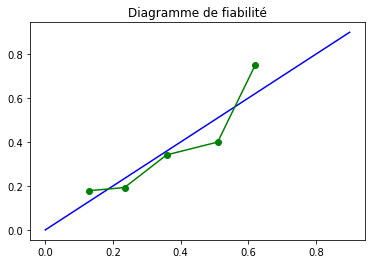

In [ ]:
# on construit le diagramme 
#en faisant apparaitre la diagonale

#et en ajoutant notre diagramme

#titre
plt.title("Diagramme de fiabilité")
#tracé
plt.show()


les points sont tout de même éloignés de la bissectrice, le modèle peut être amélioré

## 7. Evaluation des performances du modèle à l'aide de la courbe ROC

Pour évaluer un modèle le taux d’erreur semble être un indicateur synthétique pertinent, il indique (estime) la probabilité de mal classer un individu de la population.
Les autres indicateurs sont très intéressants également (sensibilité/rappel,précision/spécificité) mais obligent à surveiller plusieurs valeurs simultanément.

Mais lorsque les classes sont très déséquilibrées, la matrice de confusion et surtout le
taux d’erreur donnent souvent une fausse idée de la qualité de l’apprentissage. Doù l'intérêt de la courbe ROC!
les résultats qu'elle fournit sont valables même si l'échantillon n'est pas représentatif

cas du modèle qui ne fait pas mieux que l’affectation des probabilités
- notre courbe ne doit pas passer en dessous
- plus il s’en écarte vers le haut, mieux c’est

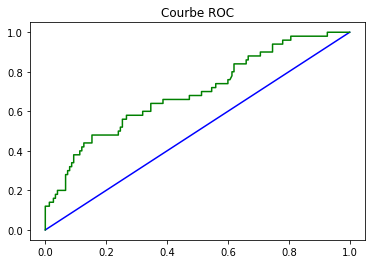

In [ ]:
# on utilise roc_curve (scikit- learn )
# on trace la diagonale de référence
#fpr (false positive rate -- taux de faux positifs) en abscisse
#tpr (true positive rate – taux de vrais positifs) en ordonnée
#pos_label = 1 pour indiquer la modalité cible


In [ ]:
# on calcule l'aire sous la courbe en faisant appel à la fonction roc_auc_score()


AUC : 0.6934


## 8. Ajustement du modèle

## 9. Selection des variables au regard de leur significativité : approche statistique 

### Via le test du rapport de vraisemblance